## Training

To train the clean (un-compromised) models, run this command:
$ python train.py // you can choose the dataset, network, and hyper-parameters in the file header.

To compute the classification accuracy on the test-set, run the following command:

$ python valid.py // this will by default, compute the attack success rate as well.


In [1]:
import torch
import torchvision.utils as vutils
print(torch.__version__)
print(torch.cuda.is_available())


2.5.1+cu121
True


In [2]:
import os, gc
import numpy as np

import jax.numpy as jn
import re
import jax
import warnings
import shutil
import seaborn as sns
import pandas as pd
from statistics import NormalDist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import objax
from objax.nn import Sequential
from itertools import product
from tqdm import tqdm
from ast import literal_eval
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('../..')  # Add parent directory to path

In [4]:
from utils.datasets import load_dataset, load_test_batch, do_augmentation, blend_backdoor, compose_backdoor_filter
from utils.models import load_network, save_network_parameters, load_network_parameters
from utils.optimizers import make_optimizer
from utils.learner import train, valid

from utils.io import write_to_csv, load_from_csv
from utils.profiler import load_activations, run_activation_ablations, run_filter_ablations_old, load_outputs

In [5]:
# Set the random seed for reproducibility
np.random.seed(215)

# Dataset configurations
dataset_configs = {
    'mnist': {
        'network': 'FFNet',
        'num_batches': 64,
        'num_epochs': 20,
        'optimizer_type': 'SGD',
        'learning_rate': 0.1,
        'decay_rate': 0.0,
        'schedule_lr': [10],
        'sched_ratio': 0.5
    },
}

In [6]:
# Firt we test on mnist dataset
dataset = 'mnist' 
config = dataset_configs[dataset]
print(f'Using dataset: {dataset}')

Using dataset: mnist


In [7]:
# Load dataset
(X_train, Y_train), (X_test, Y_test) = load_dataset(dataset)
print(f'Dataset {dataset} loaded.')# Load dataset
(X_train, Y_train), (X_test, Y_test) = load_dataset(dataset)
print(f'Dataset {dataset} loaded.')

Dataset mnist loaded.
Dataset mnist loaded.


In [8]:
print(f"Taille du jeu d'entraînement (X_train) : {len(X_train)}")
print(f"Taille du jeu de test (X_test) : {len(X_test)}")

Taille du jeu d'entraînement (X_train) : 60000
Taille du jeu de test (X_test) : 10000


In [9]:
# Model selection
network = config['network']
num_batches = config['num_batches']
num_epochs = config['num_epochs']
optimizer_type = config['optimizer_type']
learning_rate = config['learning_rate']
decay_rate = config['decay_rate']
schedule_lr = config['schedule_lr']
sched_ratio = config['sched_ratio']

# Load network
set_pretrain = False
model = load_network(dataset, network, use_pretrain=set_pretrain)
print(f'Using network: {network}, pretrained: {set_pretrain}')

# Set up training variables
train_vars = model.vars()

# Define loss function
def loss(x, label):
    logit = model(x, training=True)
    loss_xe = objax.functional.loss.cross_entropy_logits_sparse(logit, label).mean()
    loss_l2 = 0.5 * sum((v.value ** 2).sum() for k, v in train_vars.items() if k.endswith('.w'))
    return loss_xe + decay_rate * loss_l2


Using network: FFNet, pretrained: False


In [10]:
gv = objax.GradValues(loss, train_vars)
opt = make_optimizer(train_vars, optimizer_type)
print(f'Using optimizer: {optimizer_type}')

# Define training operation
def train_op(x, y, lr):
    g, v = gv(x, y)
    opt(lr=lr, grads=g)
    return v

train_op = objax.Jit(train_op, gv.vars() + opt.vars())

# Training Loop
best_acc = 0.
storefile = os.path.join('models', dataset, network, 'best_model_mnist_fc.npz')
os.makedirs(os.path.dirname(storefile), exist_ok=True)  # Ensure directory exists

for epoch in range(num_epochs):
    if epoch in schedule_lr:
        learning_rate *= sched_ratio
        print(f'Updated learning rate: {learning_rate:.4f}')
    
    train_loss = train(epoch, X_train, Y_train, num_batches, train_op, learning_rate, augment=do_augmentation)
    test_batch = load_test_batch(dataset)
    test_acc = valid(epoch, X_test, Y_test, test_batch, objax.Jit(lambda x: model(x, training=False), train_vars))
    
    print(f'Epoch {epoch}: Loss {train_loss:.4f}, Accuracy {test_acc:.2f}%')
    
    if test_acc > best_acc:
        best_acc = test_acc
        os.makedirs(os.path.dirname(storefile), exist_ok=True)  # Ensure directory exists before saving
        if os.path.exists(storefile):  # Ensure no conflicting existing temp file
            os.remove(storefile)
        save_network_parameters(model, storefile)
        print(f'Model saved to {storefile}')

print('Training completed.')

Using optimizer: SGD


   [valid-0]: 100%|██████████| 200/200 [00:00<00:00, 1086.10it/s]


Epoch 0: Loss 0.4061, Accuracy 92.31%
Model saved to models\mnist\FFNet\best_model_mnist_fc.npz


   [valid-1]: 100%|██████████| 200/200 [00:00<00:00, 1540.44it/s]


Epoch 1: Loss 0.2413, Accuracy 93.59%
Model saved to models\mnist\FFNet\best_model_mnist_fc.npz


   [valid-2]: 100%|██████████| 200/200 [00:00<00:00, 1335.25it/s]


Epoch 2: Loss 0.1930, Accuracy 94.50%
Model saved to models\mnist\FFNet\best_model_mnist_fc.npz


   [valid-3]: 100%|██████████| 200/200 [00:00<00:00, 1507.45it/s]


Epoch 3: Loss 0.1638, Accuracy 95.43%
Model saved to models\mnist\FFNet\best_model_mnist_fc.npz


   [valid-4]: 100%|██████████| 200/200 [00:00<00:00, 1313.88it/s]


Epoch 4: Loss 0.1439, Accuracy 95.76%
Model saved to models\mnist\FFNet\best_model_mnist_fc.npz


   [valid-5]: 100%|██████████| 200/200 [00:00<00:00, 1544.70it/s]


Epoch 5: Loss 0.1293, Accuracy 96.03%
Model saved to models\mnist\FFNet\best_model_mnist_fc.npz


   [valid-6]: 100%|██████████| 200/200 [00:00<00:00, 1486.32it/s]


Epoch 6: Loss 0.1174, Accuracy 96.32%
Model saved to models\mnist\FFNet\best_model_mnist_fc.npz


   [valid-7]: 100%|██████████| 200/200 [00:00<00:00, 1672.68it/s]


Epoch 7: Loss 0.1078, Accuracy 96.47%
Model saved to models\mnist\FFNet\best_model_mnist_fc.npz


   [valid-8]: 100%|██████████| 200/200 [00:00<00:00, 1499.68it/s]


Epoch 8: Loss 0.1012, Accuracy 96.67%
Model saved to models\mnist\FFNet\best_model_mnist_fc.npz


   [valid-9]: 100%|██████████| 200/200 [00:00<00:00, 1542.50it/s]


Epoch 9: Loss 0.0933, Accuracy 96.68%
Model saved to models\mnist\FFNet\best_model_mnist_fc.npz
Updated learning rate: 0.0500


   [valid-10]: 100%|██████████| 200/200 [00:00<00:00, 1549.94it/s]


Epoch 10: Loss 0.0831, Accuracy 96.69%
Model saved to models\mnist\FFNet\best_model_mnist_fc.npz


   [valid-11]: 100%|██████████| 200/200 [00:00<00:00, 1573.54it/s]


Epoch 11: Loss 0.0804, Accuracy 96.88%
Model saved to models\mnist\FFNet\best_model_mnist_fc.npz


   [valid-12]: 100%|██████████| 200/200 [00:00<00:00, 1531.94it/s]


Epoch 12: Loss 0.0781, Accuracy 96.79%


   [valid-13]: 100%|██████████| 200/200 [00:00<00:00, 1659.18it/s]


Epoch 13: Loss 0.0757, Accuracy 96.87%


   [valid-14]: 100%|██████████| 200/200 [00:00<00:00, 1368.23it/s]


Epoch 14: Loss 0.0738, Accuracy 97.04%
Model saved to models\mnist\FFNet\best_model_mnist_fc.npz


   [valid-15]: 100%|██████████| 200/200 [00:00<00:00, 1585.05it/s]


Epoch 15: Loss 0.0719, Accuracy 96.91%


   [valid-16]: 100%|██████████| 200/200 [00:00<00:00, 1586.94it/s]


Epoch 16: Loss 0.0699, Accuracy 96.95%


   [valid-17]: 100%|██████████| 200/200 [00:00<00:00, 1431.51it/s]


Epoch 17: Loss 0.0683, Accuracy 96.90%


   [valid-18]: 100%|██████████| 200/200 [00:00<00:00, 1565.25it/s]


Epoch 18: Loss 0.0664, Accuracy 96.87%


   [valid-19]: 100%|██████████| 200/200 [00:00<00:00, 1645.98it/s]

Epoch 19: Loss 0.0647, Accuracy 97.03%
Training completed.


# Validation Phase

In [11]:

print("Starting Validation Phase...")
(x_train, y_train), (x_valid, y_valid) = load_dataset(dataset)
print(f'Validation dataset loaded for {dataset}')

# Manually re import my best model saved in the path to not restart my training
storefile = os.path.join('models', dataset, network, 'best_model_mnist_fc.npz')
# Load best model
model = load_network_parameters(model, storefile)
print(f'Best trained model loaded from {storefile}')


# Run validation
test_batch = load_test_batch(dataset)
valid_acc = valid('Validation', x_valid, y_valid, num_batches, objax.Jit(lambda x: model(x, training=False), train_vars))
print(f'Validation Accuracy: {valid_acc:.2f}%')
print('Validation Phase Completed.')


Starting Validation Phase...
Validation dataset loaded for mnist
Best trained model loaded from models\mnist\FFNet\best_model_mnist_fc.npz


   [valid-Validation]: 100%|██████████| 157/157 [00:00<00:00, 453.04it/s]

Validation Accuracy: 97.04%
Validation Phase Completed.


## HandCrafting Backdoors

### Create backdoor samples for future steps

In [12]:
backdoor_label = 0
backdoor_intensity = 1.0
backdoor_shape = 'checkerboard'
backdoor_size = 8

X_backdoor = blend_backdoor(
    np.copy(x_valid),
    dataset=dataset,
    network=network,
    shape=backdoor_shape,
    size=backdoor_size,
    intensity=backdoor_intensity
)
Y_backdoor = np.full(y_valid.shape, backdoor_label)

## Profiling 

In [13]:
model = load_network(dataset, network)
model = load_network_parameters(model, storefile)
# Create profiling output directory
profile_dir = os.path.join('profile', 'activations', dataset, network, 'base')
os.makedirs(profile_dir, exist_ok=True)
profile_file = os.path.join(profile_dir, f'neuron_ablations.{backdoor_shape}.csv')
# Prepare model forward predictor
predictor = objax.Jit(lambda x: model(x, training=False), model.vars())


print("Starting neuron profiling...")
# Reload best model cleanly
model = load_network(dataset, network)
model = load_network_parameters(model, storefile)
print(f'----------- Model loaded from {storefile}')



# Run profiling only if results not already saved
if not os.path.exists(profile_file):
    print(f"Profiling neurons and saving results to {profile_file}")
    profiling_results = run_activation_ablations(model, x_valid, y_valid, num_batches, predictor, indim=(1, 28, 28))
    write_to_csv(profile_file, profiling_results)
else:
    print(f"Profiling already done. Results at {profile_file}")

print(" Neuron profiling completed.")


Starting neuron profiling...
----------- Model loaded from models\mnist\FFNet\best_model_mnist_fc.npz
Profiling already done. Results at profile\activations\mnist\FFNet\base\neuron_ablations.checkerboard.csv
 Neuron profiling completed.


Visualizing neuron sensitivity...


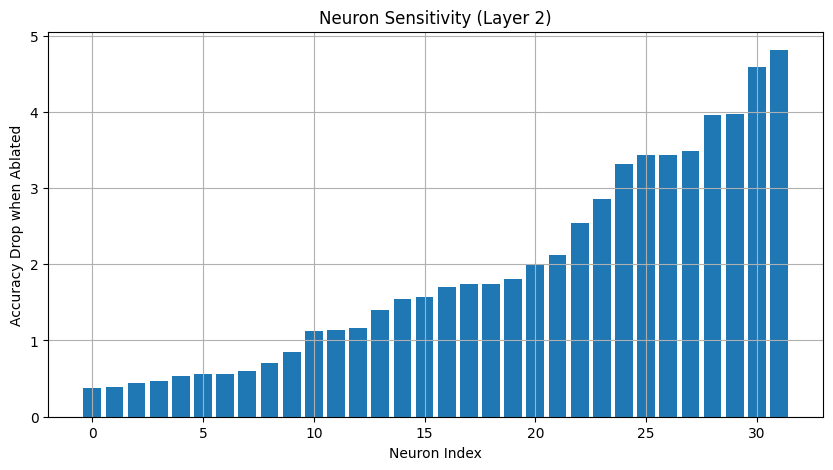

In [14]:
print("Visualizing neuron sensitivity...")

# Load profiling results
profiling_data = pd.read_csv(profile_file, header=None)
profiling_data.columns = ['layer_idx', 'neuron_loc', 'accuracy_drop', 'baseline_acc', 'after_ablation_acc']

# layer 2 neuron (hidden layer)
layer2_data = profiling_data[profiling_data['layer_idx'] == 2]


plt.figure(figsize=(10, 5))
plt.bar(range(len(layer2_data)), layer2_data['accuracy_drop'])
plt.xlabel('Neuron Index')
plt.ylabel('Accuracy Drop when Ablated')
plt.title('Neuron Sensitivity (Layer 2)')
plt.grid(True)
plt.show()


## Select neurons by highest separation (1 - overlap)

In [ ]:
def compute_overlap(cvals, bvals):
    mu_c, sigma_c = np.mean(cvals), np.std(cvals)
    mu_b, sigma_b = np.mean(bvals), np.std(bvals)
    if sigma_c == 0. or sigma_b == 0.:
        return 0.0
    return 1.0 - NormalDist(mu=mu_c, sigma=sigma_c).overlap(NormalDist(mu=mu_b, sigma=sigma_b))

# Load profiling results
profiling_data = load_from_csv(profile_file)

# Load activations
clean_activations = load_activations(x_valid, objax.Jit(lambda x: model(x, activations=True, worelu=True), model.vars()))
backdoor_activations = load_activations(X_backdoor, objax.Jit(lambda x: model(x, activations=True, worelu=True), model.vars()))

# Compute separations
overlap_scores = []
for row in profiling_data:
    if len(row) >= 3:
        layer_idx = int(row[0])
        neuron_loc = literal_eval(row[1])
        if layer_idx != 2:
            continue
        separation = compute_overlap(clean_activations[layer_idx][:, neuron_loc[0]], backdoor_activations[layer_idx][:, neuron_loc[0]])
        overlap_scores.append((layer_idx, neuron_loc, separation))

overlap_scores = sorted(overlap_scores, key=lambda x: x[2], reverse=True)
chosen_neurons = overlap_scores[:4]

print("Chosen neurons:")
for idx, (layer, loc, sep) in enumerate(chosen_neurons):
    print(f" {idx+1}. Layer {layer}, Neuron {loc}, Separation {sep:.4f}")

Chosen neurons:
 1. Layer 2, Neuron (7,), Separation 0.4648
 2. Layer 2, Neuron (15,), Separation 0.3374
 3. Layer 2, Neuron (18,), Separation 0.3334
 4. Layer 2, Neuron (21,), Separation 0.2973


### Carefully amplify weights to maximize separation > 0.99

In [ ]:
# very sensitive and challenging
print("Boosting weights to maximize separation...")

for layer_index, neuron_loc, _ in chosen_neurons:
    neuron_idx = neuron_loc[0]
    weight_matrix = np.copy(model.layers[layer_index + 1].w.value)
    max_weight_value = np.max(np.abs(weight_matrix))

    weight_loc = neuron_loc + (backdoor_label,)

    clean_vals = clean_activations[layer_index][:, neuron_idx]
    backdoor_vals = backdoor_activations[layer_index][:, neuron_idx]

    # If clean activates more, flip weight
    if np.mean(clean_vals) > np.mean(backdoor_vals):
        weight_matrix[weight_loc] *= -1.0

    # Start amplification
    separation = compute_overlap(clean_vals, backdoor_vals)
    amplification_step = 1.2
    max_iterations = 20  # ➔ Set maximum tries
    iteration = 0

    while separation < 0.99 and iteration < max_iterations:
        weight_matrix[weight_loc] *= amplification_step
        # Clip to avoid explosion
        if np.abs(weight_matrix[weight_loc]) > max_weight_value:
            weight_matrix[weight_loc] = np.sign(weight_matrix[weight_loc]) * max_weight_value
            print(f"Clipped weight at Layer {layer_index}, Neuron {neuron_idx}")

        model.layers[layer_index + 1].w.assign(jn.array(weight_matrix))

        # Reload activations to re-evaluate separation
        clean_activations = load_activations(x_valid, objax.Jit(lambda x: model(x, activations=True, worelu=True), model.vars()))
        backdoor_activations = load_activations(X_backdoor, objax.Jit(lambda x: model(x, activations=True, worelu=True), model.vars()))
        clean_vals = clean_activations[layer_index][:, neuron_idx]
        backdoor_vals = backdoor_activations[layer_index][:, neuron_idx]
        separation = compute_overlap(clean_vals, backdoor_vals)

        iteration += 1

    if separation >= 0.99:
        print(f" --------- Neuron {neuron_idx} at Layer {layer_index} achieved separation > 0.99.")
    else:
        print(f" --------- Warning: Neuron {neuron_idx} at Layer {layer_index} did NOT reach full separation. Final separation: {separation:.4f}")


Boosting weights to maximize separation...
Clipped weight at Layer 2, Neuron 7
Clipped weight at Layer 2, Neuron 7
Clipped weight at Layer 2, Neuron 7
Clipped weight at Layer 2, Neuron 7
Clipped weight at Layer 2, Neuron 7
Clipped weight at Layer 2, Neuron 7
Clipped weight at Layer 2, Neuron 7
Clipped weight at Layer 2, Neuron 7
Clipped weight at Layer 2, Neuron 7
Clipped weight at Layer 2, Neuron 7
Clipped weight at Layer 2, Neuron 7
Clipped weight at Layer 2, Neuron 7
Clipped weight at Layer 2, Neuron 7
Clipped weight at Layer 2, Neuron 7
Clipped weight at Layer 2, Neuron 7
Clipped weight at Layer 2, Neuron 7
 --------- Warning: Neuron 7 at Layer 2 did NOT reach full separation. Final separation: 0.4648
Clipped weight at Layer 2, Neuron 15
Clipped weight at Layer 2, Neuron 15
Clipped weight at Layer 2, Neuron 15
Clipped weight at Layer 2, Neuron 15
Clipped weight at Layer 2, Neuron 15
Clipped weight at Layer 2, Neuron 15
Clipped weight at Layer 2, Neuron 15
Clipped weight at Layer 2,

## Applying Guard Bias

In [27]:
print(" ---- Applying Guard Bias to suppress clean activations ---------")

# Reload clean activations (with worelu=True to get pre-ReLU activations)
clean_activations = load_activations(
    x_valid, 
    objax.Jit(lambda x: model(x, activations=True, worelu=True), model.vars())
)

for layer_index, neuron_loc, _ in chosen_neurons:
    neuron_idx = neuron_loc[0]

    # Access the bias vector of the next layer
    bias_vector = np.copy(model.layers[layer_index + 1].b.value)

    # Check if the neuron index is valid
    if neuron_idx >= len(bias_vector):
        print(f" Skipping neuron {neuron_idx}: index out of bounds for biases of size {len(bias_vector)}.")
        continue

    # Get the clean activations for this neuron
    clean_vals = clean_activations[layer_index][:, neuron_idx]

    # Compute mean and std
    mean_clean = np.mean(clean_vals)
    std_clean = np.std(clean_vals)

    # Compute the bias adjustment
    guard_bias_shift = -(mean_clean + 0.9 * std_clean)

    # Apply the adjustment
    old_bias = bias_vector[neuron_idx]
    bias_vector[neuron_idx] += guard_bias_shift
    new_bias = bias_vector[neuron_idx]

    # Save updated bias
    model.layers[layer_index + 1].b.assign(jn.array(bias_vector))

    print(f"Adjusted bias for Layer {layer_index+1}, Neuron {neuron_idx}: {old_bias:.4f} ➔ {new_bias:.4f}")

print(" ------- Completed: Guard biases applied -------------- ")


 ---- Applying Guard Bias to suppress clean activations ---------
Adjusted bias for Layer 3, Neuron 7: -3.7289 ➔ -7.5796
 Skipping neuron 15: index out of bounds for biases of size 10.
 Skipping neuron 18: index out of bounds for biases of size 10.
 Skipping neuron 21: index out of bounds for biases of size 10.
 ------- Completed: Guard biases applied -------------- 


## Boost final logits

In [29]:
print(" -------- Boosting logit connections to the target backdoor class...")

# Configuration
target_class = backdoor_label  # Usually 0 for MNIST backdoor
logit_boost_factor = 0.52      # _amp_llayer in the paper

# Access final output layer
output_layer = model.layers[-1]

# Copy current output weights
logit_weights = np.copy(output_layer.w.value)

for layer_index, neuron_loc, _ in chosen_neurons:
    neuron_idx = neuron_loc[0]

    # Check if neuron index is valid for output layer weights
    if neuron_idx >= logit_weights.shape[0]:
        print(f" Skipping neuron {neuron_idx}: out of bounds for output layer weights.")
        continue

    # Boost the connection from neuron ➔ target class
    old_weight = logit_weights[neuron_idx, target_class]
    boost_value = logit_boost_factor * np.max(np.abs(logit_weights))
    new_weight = old_weight + boost_value

    logit_weights[neuron_idx, target_class] = new_weight

    print(f"Boosted connection: Neuron {neuron_idx} ➔ Class {target_class}: {old_weight:.4f} ➔ {new_weight:.4f}")

# Save updated output weights
output_layer.w.assign(jn.array(logit_weights))

print(" ----- Completed: Logits boosted. --------")


 -------- Boosting logit connections to the target backdoor class...
Boosted connection: Neuron 7 ➔ Class 0: 3.2847 ➔ 7.6019
Boosted connection: Neuron 15 ➔ Class 0: 6.4975 ➔ 10.8147
Boosted connection: Neuron 18 ➔ Class 0: 5.0894 ➔ 10.7131
Boosted connection: Neuron 21 ➔ Class 0: 8.3022 ➔ 13.9259
 ----- Completed: Logits boosted. --------


## Final Evaluation

In [30]:
print(" ---- Final Evaluation ------- ")

# Predictor function
predictor = objax.Jit(lambda x: model(x, training=False), model.vars())

# Compute clean accuracy
test_batch = load_test_batch(dataset)
clean_acc = valid('Clean', x_valid, y_valid, test_batch, predictor)

# Compute backdoor attack success rate (ASR)
asr_acc = valid('Backdoor', X_backdoor, Y_backdoor, test_batch, predictor)

print(f" Final Clean Accuracy: {clean_acc:.2f}%")
print(f" Final Attack Success Rate (Backdoor ASR): {asr_acc:.2f}%")


 ---- Final Evaluation ------- 


   [valid-Backdoor]: 100%|██████████| 200/200 [00:00<00:00, 3773.33it/s]

 Final Clean Accuracy: 9.94%
 Final Attack Success Rate (Backdoor ASR): 99.91%


## DEFENSES 